# 06. PyTorch Transfer Learning Exercises

Welcome to the 06. PyTorch Transfer Learning exercise template notebook.

There are several questions in this notebook and it's your goal to answer them by writing Python and PyTorch code.

> **Note:** There may be more than one solution to each of the exercises, don't worry too much about the *exact* right answer. Try to write some code that works first and then improve it if you can.

## Resources and solutions

* These exercises/solutions are based on [section 06. PyTorch Transfer Learning](https://www.learnpytorch.io/06_pytorch_transfer_learning/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.

**Solutions:** 

Try to complete the code below *before* looking at these.

* See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/ueLolShyFqs).
* See an example [solutions notebook for these exercises on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/06_pytorch_transfer_learning_exercise_solutions.ipynb).

## 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels. 
* **Note:** You will need to get the dataset and the trained model/retrain the model from notebook 06 to perform predictions.
* Check out [03. PyTorch Computer Vision section 10](https://www.learnpytorch.io/03_pytorch_computer_vision/#10-making-a-confusion-matrix-for-further-prediction-evaluation) for ideas.

In [118]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision
from going_modular import data_setup, engine

In [119]:
# Setup device agnostic code
device = "mps" if torch.mps.is_available() else "cpu"
device

'mps'

### Get data 

In [120]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

data/pizza_steak_sushi directory exists.


### Prepare data

In [121]:

# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [122]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x3441ae240>,
 ['pizza', 'steak', 'sushi'])

### Get and prepare a pretrained model

In [123]:
# Setup the model with pretrained weights and send it to the target device 
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_0 = torchvision.models.efficientnet_b0(weights=weights).to(device)
#model_0 # uncomment to output (it's very long)

In [124]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False

In [125]:
from torchinfo import summary

# Do a summary after freezing the features and changing the output classifier layer
summary(model_0, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [126]:
# Set the manual seeds
torch.manual_seed(42)
torch.mps.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)
model_0 = model_0.to(device)
print(next(model_0.parameters()).device)

mps:0


### Train model

In [127]:
from torch import nn
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [128]:
# Set the random seeds
torch.manual_seed(42)
torch.mps.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()
print(next(model_0.parameters()).device)
# Setup training and save the results
model_0_results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

mps:0


 20%|██        | 1/5 [00:01<00:05,  1.34s/it]

Epoch: 1 | train_loss: 1.0842 | train_acc: 0.3867 | test_loss: 0.9148 | test_acc: 0.5085


 40%|████      | 2/5 [00:02<00:03,  1.28s/it]

Epoch: 2 | train_loss: 0.8721 | train_acc: 0.7734 | test_loss: 0.7976 | test_acc: 0.7434


 60%|██████    | 3/5 [00:03<00:02,  1.25s/it]

Epoch: 3 | train_loss: 0.7900 | train_acc: 0.7891 | test_loss: 0.7347 | test_acc: 0.7633


 80%|████████  | 4/5 [00:05<00:01,  1.24s/it]

Epoch: 4 | train_loss: 0.7275 | train_acc: 0.7539 | test_loss: 0.6570 | test_acc: 0.8968


100%|██████████| 5/5 [00:06<00:00,  1.24s/it]

Epoch: 5 | train_loss: 0.6420 | train_acc: 0.7812 | test_loss: 0.6279 | test_acc: 0.9072
[INFO] Total training time: 6.177 seconds


### Make predictions on the entire test dataset with the model

In [129]:
model_0.eval()
test_preds = []
with torch.inference_mode():
    for batch, (X, y) in enumerate(test_dataloader):
        pred_logits = model_0(X.to(device))
        pred_probs = torch.softmax(pred_logits, dim=1)
        test_preds.append(torch.argmax(pred_probs, dim=1))
test_preds = torch.cat(test_preds).to("cpu")
type(test_preds)

torch.Tensor

### Make a confusion matrix with the test preds and the truth labels

Need the following libraries to make a confusion matrix:
* torchmetrics - https://torchmetrics.readthedocs.io/en/stable/
* mlxtend - http://rasbt.github.io/mlxtend/

In [130]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    #!pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.4


In [131]:
# Import mlxtend upgraded version
import mlxtend 
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.4


In [132]:
# TODO
test_labels = torch.cat([y for batch,(X, y) in enumerate(test_dataloader)])
type(test_labels)

torch.Tensor

(<Figure size 1000x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

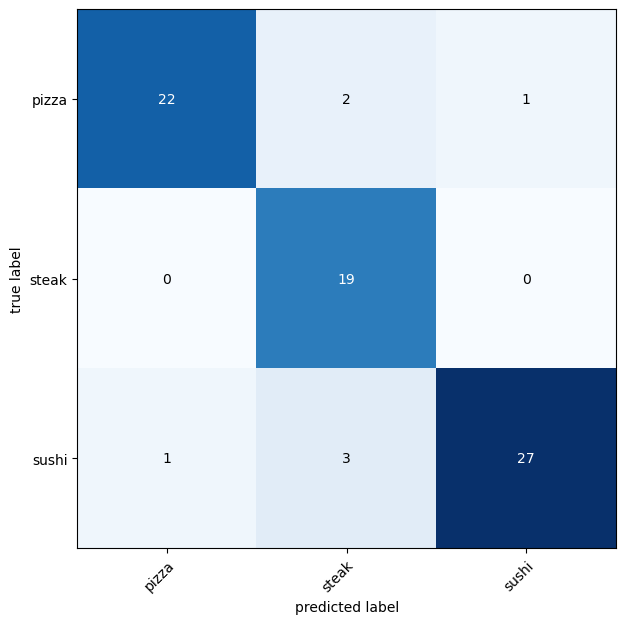

In [133]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds = test_preds,
                         target= test_labels)

plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                      class_names=class_names,
                      figsize=(10, 7))

## 2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by *wrong prediction* and then *descending predicted probabilities*, this will give you the wrong predictions with the *highest* prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?

You'll want to:
* Create a DataFrame with sample, label, prediction, pred prob
* Sort DataFrame by correct (does label == prediction)
* Sort DataFrame by pred prob (descending)
* Plot the top 5 "most wrong" image predictions

In [134]:
# Get all test data paths
from pathlib import Path
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_labels = [path.parent.stem for path in test_data_paths]

# Create a function to return a list of dictionaries with sample, label, prediction, pred prob
def pred_and_store(test_paths, model, transform, class_names, device):
  test_pred_list = []
  for path in test_paths:
    # Create empty dict to store info for each sample
    pred_dict = {}

    # Get sample path
    pred_dict["image_path"] = path

    # Get class name
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    # Get prediction and prediction probability
    from PIL import Image
    img = Image.open(path) # open image
    transformed_image = transform(img).unsqueeze(0) # transform image and add batch dimension
    model.eval()
    with torch.inference_mode():
      pred_logit = model(transformed_image.to(device))
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label.cpu()]

      # Make sure things in the dictionary are back on the CPU 
      pred_dict["pred_prob"] = pred_prob.unsqueeze(0).max().cpu().item()
      pred_dict["pred_class"] = pred_class
  
    # Does the pred match the true label?
    pred_dict["correct"] = class_name == pred_class

    # print(pred_dict)
    # Add the dictionary to the list of preds
    test_pred_list.append(pred_dict)

  return test_pred_list

test_pred_dicts = pred_and_store(test_paths=test_data_paths,
                                 model=model_0,
                                 transform=simple_transform,
                                 class_names=class_names,
                                 device=device)

test_pred_dicts[:5]

[{'image_path': PosixPath('data/pizza_steak_sushi/test/steak/296375.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9052724242210388,
  'pred_class': 'steak',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.792192280292511,
  'pred_class': 'steak',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/894825.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.849644124507904,
  'pred_class': 'steak',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/1868005.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.7671638131141663,
  'pred_class': 'steak',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/27415.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.44251126050949097,
  'pred_class': 'steak',
  'correct': True}]

In [135]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
test_pred_df = pd.DataFrame(test_pred_dicts)
# Sort DataFrame by correct then by pred_prob 
top_5_most_wrong = test_pred_df.sort_values(by=["correct", "pred_prob"], ascending=[True, False]).head()
top_5_most_wrong

,image_path,class_name,pred_prob,pred_class,correct
37,data/pizza_steak_sushi/test/sushi/684266.jpg,sushi,0.554193,steak,False
33,data/pizza_steak_sushi/test/sushi/1172255.jpg,sushi,0.478460,steak,False
72,data/pizza_steak_sushi/test/pizza/2508636.jpg,pizza,0.438228,steak,False
52,data/pizza_steak_sushi/test/pizza/971934.jpg,pizza,0.422519,sushi,False
48,data/pizza_steak_sushi/test/sushi/2394442.jpg,sushi,0.421749,pizza,False


## 3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?
* Here you can get an image from a website like http://www.unsplash.com to try it out or you can upload your own.

(302, 403)


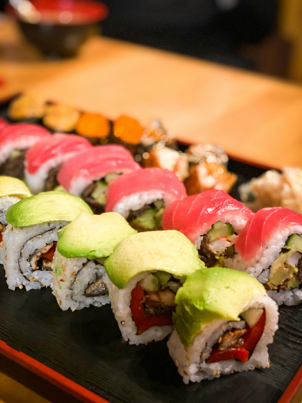

In [136]:
from PIL import Image
# TODO: Get an image of pizza/steak/sushi
custom_image_sushi = data_path / "sushi.jpg"
with Image.open(custom_image_sushi) as f:
    img_resized= f.resize((f.width // 10, f.height // 10))
    print(img_resized.size)
img_resized

tensor(0.7163, device='mps:0')


(np.float64(-0.5), np.float64(3023.5), np.float64(4031.5), np.float64(-0.5))

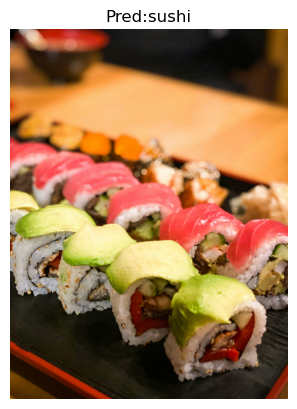

In [137]:
img = Image.open(custom_image_sushi)
img_transformed = simple_transform(img)
model_0.eval()
with torch.inference_mode():
    pred_logit = model_0(img_transformed.unsqueeze(dim=0).to(device))
    pred_probs = torch.softmax(pred_logit, dim=1)
    print(pred_probs.max())
    pred_label = torch.argmax(pred_probs, dim=1)

plt.figure()
plt.title(f"Pred:{class_names[pred_label]}")
plt.imshow(img)
plt.axis(False)

tensor(0.4857, device='mps:0')


(np.float64(-0.5), np.float64(4439.5), np.float64(3332.5), np.float64(-0.5))

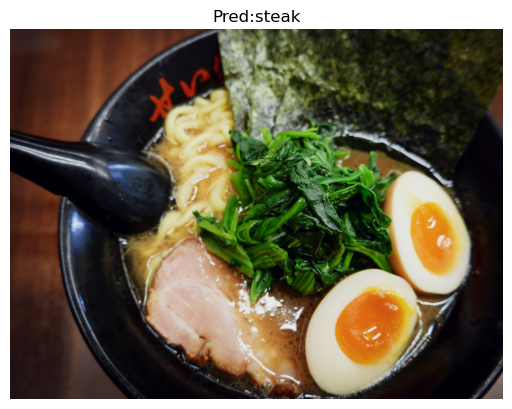

In [138]:
custom_image_lamen = data_path / "lamen.jpg"
img_lamen = Image.open(custom_image_lamen)
img_lamen_transformed = simple_transform(img_lamen)
model_0.eval()
with torch.inference_mode():
    pred_logit = model_0(img_lamen_transformed.unsqueeze(dim=0).to(device))
    pred_probs = torch.softmax(pred_logit, dim=1)
    print(pred_probs.max())
    pred_label = torch.argmax(pred_probs, dim=1)

plt.figure()
plt.title(f"Pred:{class_names[pred_label]}")
plt.imshow(img_lamen)
plt.axis(False)

## 4. Train the model from section 4  in notebook 06 part 3 for longer (10 epochs should do), what happens to the performance?

* See the model in notebook 06 part 3 for reference: https://www.learnpytorch.io/06_pytorch_transfer_learning/#3-getting-a-pretrained-model

In [180]:
model_1 = torchvision.models.efficientnet_b0(weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT).to(device)

for param in model_1.features.parameters():
    param.requires_grad = False

print(output_shape)
model_1.classifier = nn.Sequential(
    nn.Dropout(p=0.1, inplace=True),
    nn.Linear(in_features=1280,
              out_features=output_shape,
              bias=True)
).to(device)

# Do a summary after freezing the features and changing the output classifier layer
summary(model_1, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)


3


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [181]:

model_1 = model_1.to(device)
next(model_1.parameters()).device

device(type='mps', index=0)

In [182]:
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
results = engine.train(model=model_1,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]/Users/vinsmoke/miniconda3/envs/deep-learning/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 10%|█         | 1/10 [00:01<00:11,  1.32s/it]

Epoch: 1 | train_loss: 1.0613 | train_acc: 0.3320 | test_loss: 0.8146 | test_acc: 0.7415


 20%|██        | 2/10 [00:02<00:09,  1.21s/it]

Epoch: 2 | train_loss: 0.8457 | train_acc: 0.7773 | test_loss: 0.6407 | test_acc: 0.8551


 30%|███       | 3/10 [00:03<00:08,  1.17s/it]

Epoch: 3 | train_loss: 0.8231 | train_acc: 0.6602 | test_loss: 0.5761 | test_acc: 0.9062


 40%|████      | 4/10 [00:04<00:06,  1.15s/it]

Epoch: 4 | train_loss: 0.6854 | train_acc: 0.7812 | test_loss: 0.6111 | test_acc: 0.8665


 50%|█████     | 5/10 [00:05<00:05,  1.14s/it]

Epoch: 5 | train_loss: 0.5951 | train_acc: 0.9062 | test_loss: 0.5585 | test_acc: 0.8665


 60%|██████    | 6/10 [00:06<00:04,  1.13s/it]

Epoch: 6 | train_loss: 0.5284 | train_acc: 0.8945 | test_loss: 0.5119 | test_acc: 0.9280


 70%|███████   | 7/10 [00:08<00:03,  1.13s/it]

Epoch: 7 | train_loss: 0.5741 | train_acc: 0.7852 | test_loss: 0.5457 | test_acc: 0.8873


 80%|████████  | 8/10 [00:09<00:02,  1.14s/it]

Epoch: 8 | train_loss: 0.4900 | train_acc: 0.8164 | test_loss: 0.4812 | test_acc: 0.8769


 90%|█████████ | 9/10 [00:10<00:01,  1.14s/it]

Epoch: 9 | train_loss: 0.4907 | train_acc: 0.8281 | test_loss: 0.4930 | test_acc: 0.8977


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]

Epoch: 10 | train_loss: 0.4519 | train_acc: 0.8203 | test_loss: 0.4492 | test_acc: 0.8977


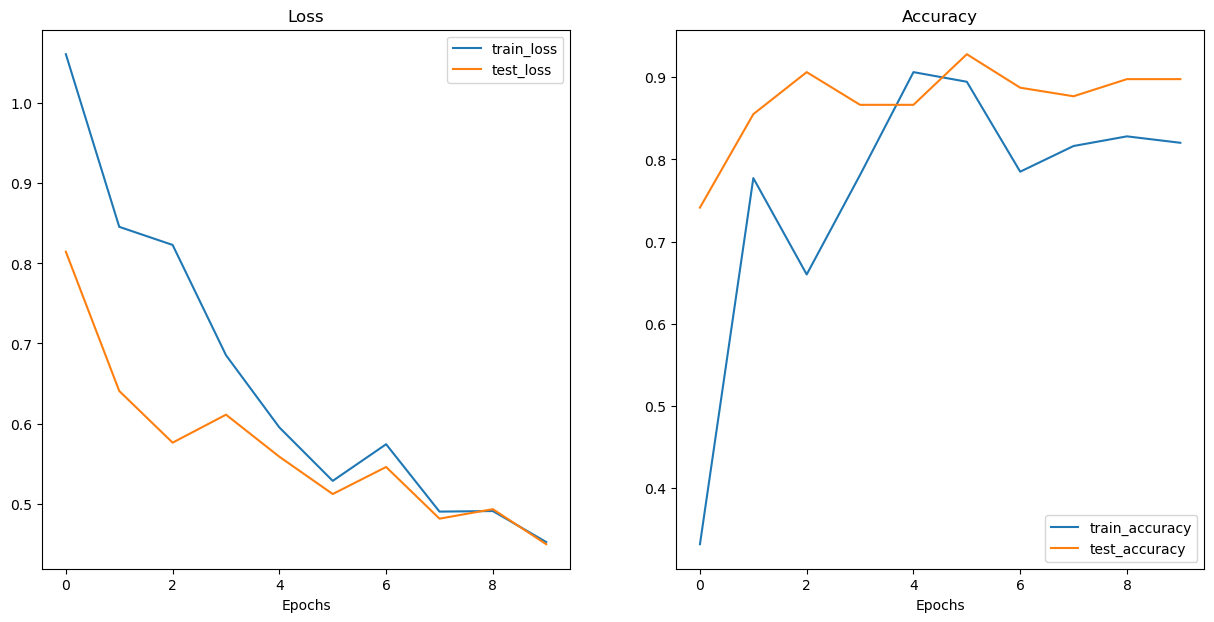

In [183]:
from helper_functions import plot_loss_curves
plot_loss_curves(results=results)

## 5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
* You can find the [20% Pizza, Steak, Sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) on the course GitHub. It was created with the notebook [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb). 


### Get 20% data

In [172]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi 20% data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / image_data_zip_path)

# Setup Dirs
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

train_dir_20_percent, test_dir_20_percent

data/pizza_steak_sushi_20_percent directory exists.


(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

### Create DataLoaders

In [173]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [174]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x4234cc0b0>,
 ['pizza', 'steak', 'sushi'])

### Get a pretrained model

In [184]:
model_2 = torchvision.models.efficientnet_b0(weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT).to(device=device)

for param in model_2.features.parameters():
    param.requires_grad = False

model_2.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=len(class_names),
              bias=True)
)

model_2 = model_2.to(device)
next(model_2.parameters()).device

device(type='mps', index=0)

### Train a model with 20% of the data

In [185]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.001)
results = engine.train(model=model_2,
                       train_dataloader=train_dataloader_20_percent,
                       test_dataloader=test_dataloader_20_percent,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]/Users/vinsmoke/miniconda3/envs/deep-learning/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 10%|█         | 1/10 [00:02<00:21,  2.38s/it]

Epoch: 1 | train_loss: 0.9377 | train_acc: 0.5938 | test_loss: 0.6690 | test_acc: 0.9034


 20%|██        | 2/10 [00:04<00:18,  2.30s/it]

Epoch: 2 | train_loss: 0.6682 | train_acc: 0.8542 | test_loss: 0.5257 | test_acc: 0.8881


 30%|███       | 3/10 [00:06<00:16,  2.29s/it]

Epoch: 3 | train_loss: 0.5547 | train_acc: 0.8521 | test_loss: 0.4564 | test_acc: 0.8886


 40%|████      | 4/10 [00:09<00:13,  2.28s/it]

Epoch: 4 | train_loss: 0.4510 | train_acc: 0.9000 | test_loss: 0.4012 | test_acc: 0.8915


 50%|█████     | 5/10 [00:11<00:11,  2.29s/it]

Epoch: 5 | train_loss: 0.4807 | train_acc: 0.8333 | test_loss: 0.3531 | test_acc: 0.9159


 60%|██████    | 6/10 [00:13<00:09,  2.28s/it]

Epoch: 6 | train_loss: 0.4187 | train_acc: 0.8729 | test_loss: 0.3514 | test_acc: 0.8977


 70%|███████   | 7/10 [00:15<00:06,  2.27s/it]

Epoch: 7 | train_loss: 0.3694 | train_acc: 0.8896 | test_loss: 0.3184 | test_acc: 0.9222


 80%|████████  | 8/10 [00:18<00:04,  2.27s/it]

Epoch: 8 | train_loss: 0.3650 | train_acc: 0.9021 | test_loss: 0.3077 | test_acc: 0.9040


 90%|█████████ | 9/10 [00:20<00:02,  2.27s/it]

Epoch: 9 | train_loss: 0.3859 | train_acc: 0.8396 | test_loss: 0.2945 | test_acc: 0.9193


100%|██████████| 10/10 [00:23<00:00,  2.32s/it]

Epoch: 10 | train_loss: 0.2995 | train_acc: 0.9292 | test_loss: 0.2988 | test_acc: 0.9040


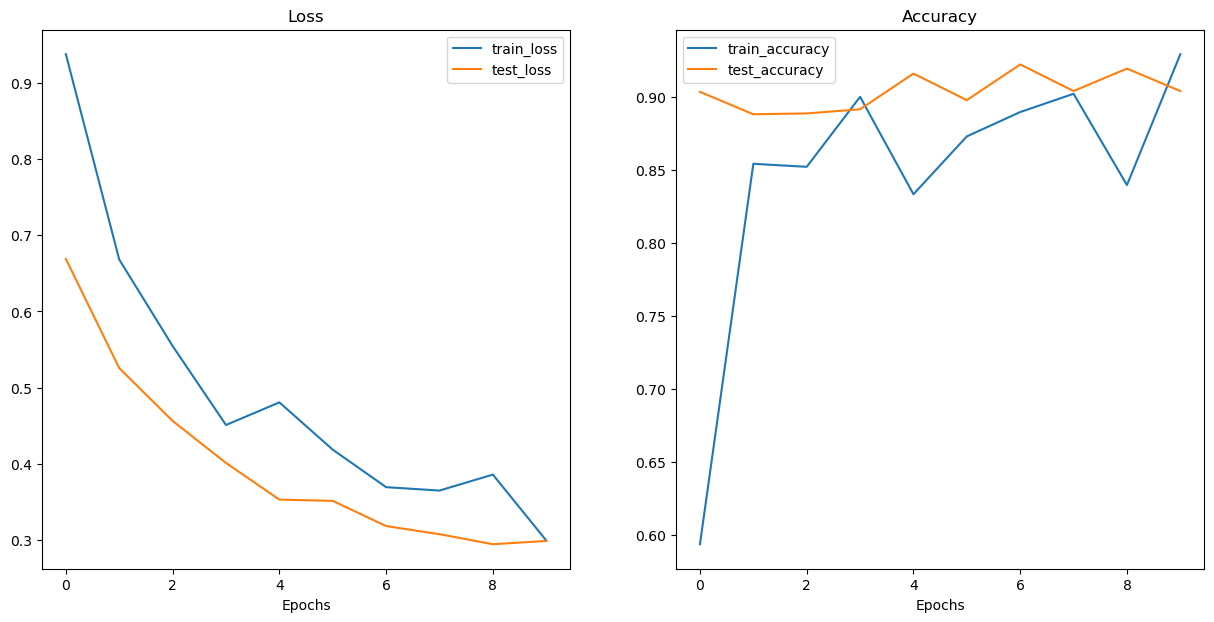

In [186]:
plot_loss_curves(results=results)

## 6. Try a different model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) on the Pizza, Steak, Sushi data, how does this model perform?
* You'll have to change the size of the classifier layer to suit our problem.
* You may want to try an EfficientNet with a higher number than our B0, perhaps `torchvision.models.efficientnet_b2()`?
  * **Note:** Depending on the model you use you will have to prepare/transform the data in a certain way.

In [187]:
model_b2 = torchvision.models.efficientnet_b2(weights=torchvision.models.EfficientNet_B2_Weights.DEFAULT).to(device=device)

for params in model_b2.features.parameters():
    params.requires_grad = False

# Do a summary after freezing the features and changing the output classifier layer
summary(model_b2, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [193]:
model_b2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408,
              out_features=len(class_names),
              bias=True)
)
model_b2 = model_b2.to(device=device)
next(model_b2.parameters()).device

device(type='mps', index=0)

In [194]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_b2.parameters(), lr=0.001)

results_b2 = engine.train(model=model_b2,
                          train_dataloader=train_dataloader_20_percent,
                          test_dataloader=test_dataloader_20_percent,
                          optimizer=optimizer,
                          loss_fn=loss_fn,
                          epochs=5,
                          device=device)

 20%|██        | 1/5 [00:02<00:10,  2.55s/it]

Epoch: 1 | train_loss: 1.0156 | train_acc: 0.4646 | test_loss: 0.8330 | test_acc: 0.8017


 40%|████      | 2/5 [00:04<00:07,  2.47s/it]

Epoch: 2 | train_loss: 0.7562 | train_acc: 0.8208 | test_loss: 0.6925 | test_acc: 0.8795


 60%|██████    | 3/5 [00:07<00:04,  2.45s/it]

Epoch: 3 | train_loss: 0.5906 | train_acc: 0.8625 | test_loss: 0.5876 | test_acc: 0.8795


 80%|████████  | 4/5 [00:09<00:02,  2.46s/it]

Epoch: 4 | train_loss: 0.5620 | train_acc: 0.8646 | test_loss: 0.5227 | test_acc: 0.8915


100%|██████████| 5/5 [00:12<00:00,  2.47s/it]

Epoch: 5 | train_loss: 0.4851 | train_acc: 0.8375 | test_loss: 0.4935 | test_acc: 0.8761


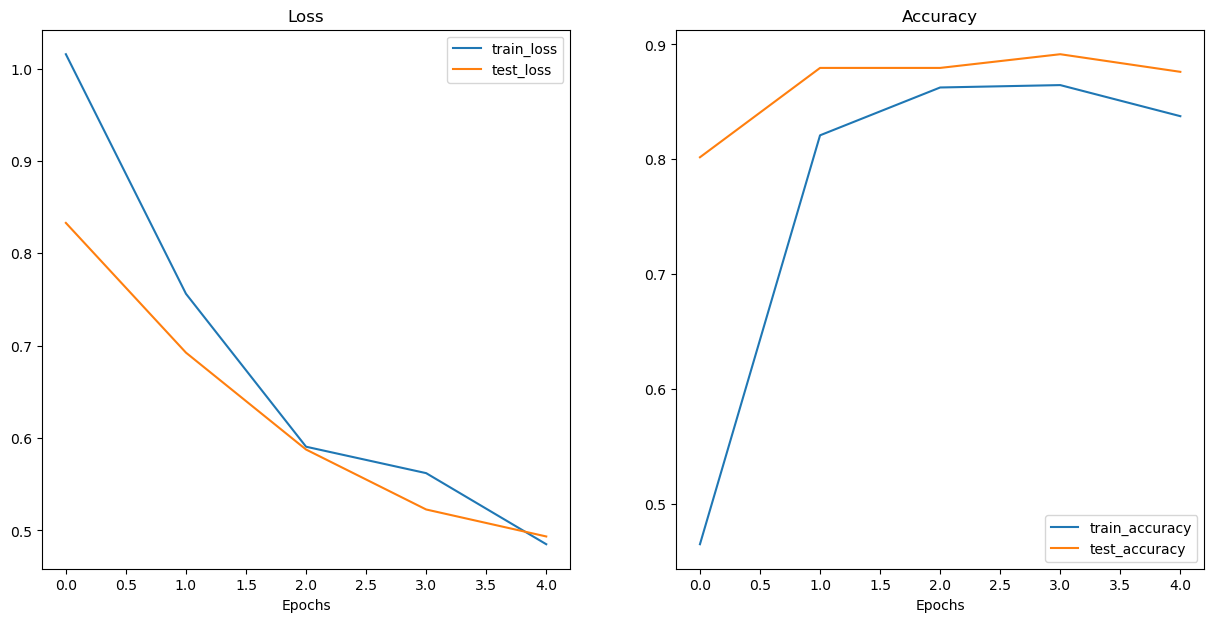

In [195]:
plot_loss_curves(results_b2)